In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from collections import Counter

In [11]:
# Get dataset
# Setting their path

train_folder = pathlib.Path("C:/Users/Andy/Desktop/ML/CSCN8010-lab-submissions/students_submissions/8920299/lab10/train")
test_folder = pathlib.Path('C:/Users/Andy/Desktop/ML/CSCN8010-lab-submissions/students_submissions/8920299/lab10/test')
valid_folder = pathlib.Path('C:/Users/Andy/Desktop/ML/CSCN8010-lab-submissions/students_submissions/8920299/lab10/valid')

train_folder

WindowsPath('C:/Users/Andy/Desktop/ML/CSCN8010-lab-submissions/students_submissions/8920299/lab10/train')

In [16]:
# Identify Top 3 Classes
def count_images_per_class(directory):
    class_counts = Counter()
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts


class_counts = count_images_per_class(train_folder)
print(len(class_counts))
top_3_class = sorted(class_counts, key=class_counts.get, reverse=True)[:3]
print("Top 3 Classes:", top_3_class)

525
Top 3 Classes: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [17]:
# delete the folders that are not top 3 class so that dataset is organized and limited to what we need only.


for species in os.listdir(train_folder):
    if species not in top_3_class:
        delete_path_train = os.path.join(train_folder, species)
        shutil.rmtree(delete_path_train)

for species in os.listdir(test_folder):
    if species not in top_3_class:
        delete_path_test = os.path.join(test_folder, species)
        shutil.rmtree(delete_path_test)

for species in os.listdir(valid_folder):
    if species not in top_3_class:
        delete_path_valid = os.path.join(valid_folder, species)
        shutil.rmtree(delete_path_valid)

##2. Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)

In [18]:
# Storing all datasets in list to iterate
folders = [train_folder, valid_folder, test_folder]

datasets = []

# Looping through datasets and appending in empty list
for folder in folders:
    dataset = image_dataset_from_directory(
        directory=folder,
        image_size=(224, 224),
        batch_size=32
    )
    datasets.append(dataset)

# Unpack datasets into individual variables
train_dataset, validation_dataset, test_dataset = datasets


Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


In [20]:
from keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
data_generator_params = {
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

# Create ImageDataGenerator instance
data_generator = ImageDataGenerator(**data_generator_params )

# Define common generator parameters
generator_params = {
    'target_size': (224, 224),
    'batch_size': 32,
    'class_mode': 'categorical'
}

# Create generators for training and validation
train_generator = data_generator.flow_from_directory(
    directory=train_folder,
    **generator_params
)

validation_generator = data_generator.flow_from_directory(
    directory=valid_folder,
    **generator_params
)


Found 744 images belonging to 3 classes.


Found 15 images belonging to 3 classes.


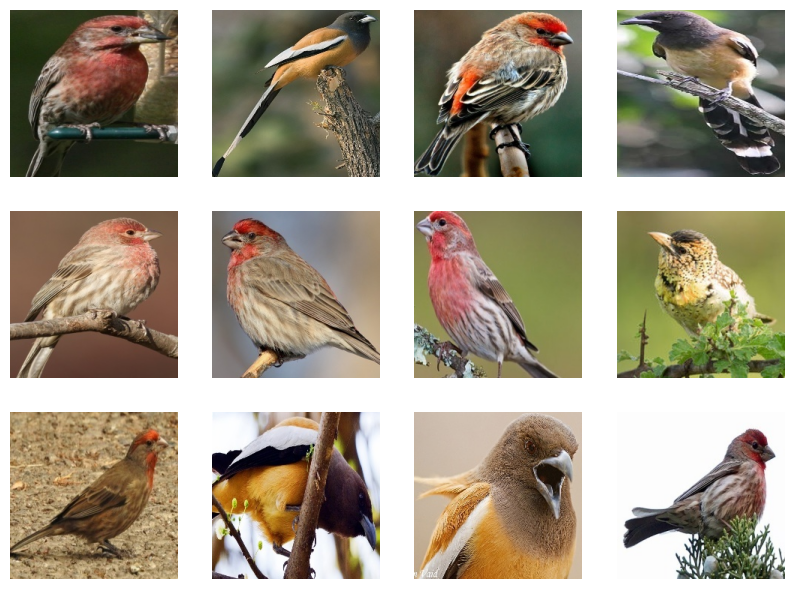

In [28]:

# Number of images to display
num_images = 12

# Fetch few 
images, _ = next(train_generator)

# Plot the images
plt.figure(figsize=(10, 10))

for i in range(num_images):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")

plt.show()


##3. Fine-Tune `VGG16` (pre-trained on `imagenet`), to classify the 3 classes (2 points)